In [26]:
%config Application.log_level='INFO'
import logging
logging.getLogger().setLevel(logging.INFO)
log = logging.getLogger()

In [1]:
%load_ext autoreload

In [12]:
%autoreload 2

In [28]:
import model_opt

I0214 14:33:26.653067 140680182429504 model_opt.py:55] Loading data
I0214 14:33:26.654973 140680182429504 model_opt.py:60] 1581687206
I0214 14:33:27.270828 140680182429504 model_opt.py:124] Creating model
I0214 14:33:27.914760 140680182429504 model_opt.py:187] Start Training
I0214 14:33:45.783409 140680182429504 model_opt.py:190] Saving training metadata


[0.530925426254023, 0.6470368131394975]


<Figure size 432x288 with 0 Axes>

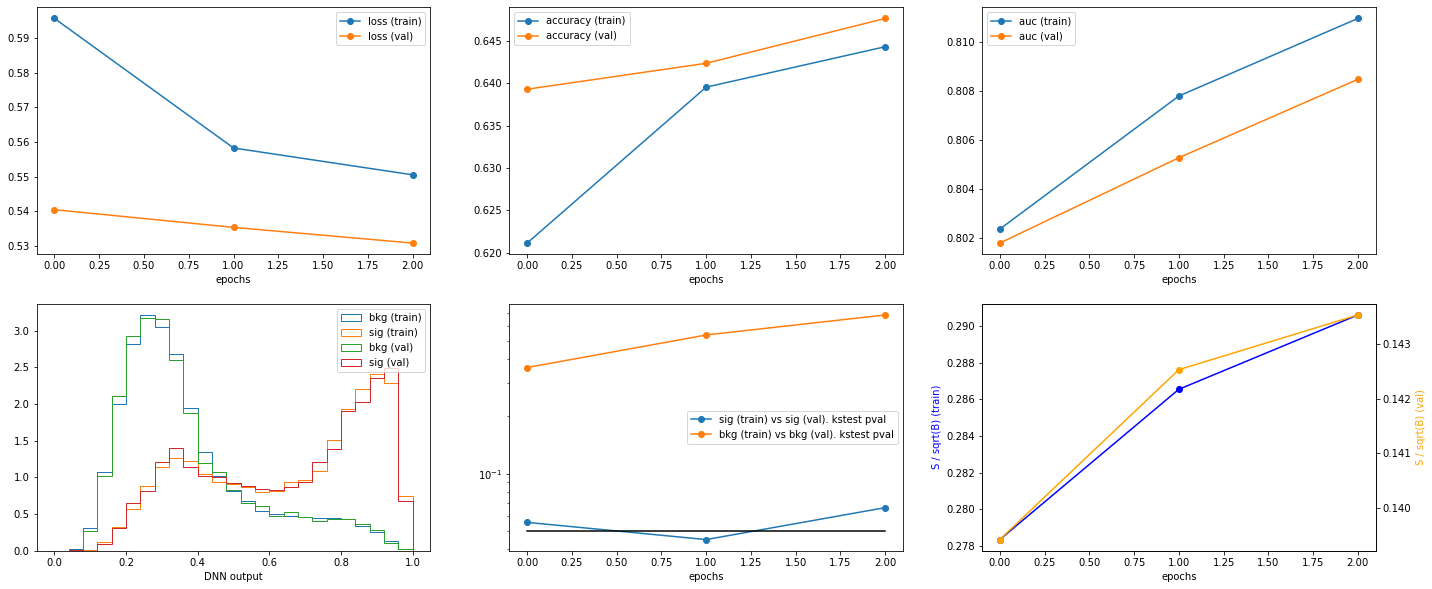

In [41]:
ev = model_opt.test_vbsdnn_model()
print(ev)

## GPyOpt

In [62]:
# !pip3 install --user gpyopt

import GPyOpt

In [80]:
config = {
    "base_dir":        "/eos/home-d/dmapelli/public/latino/",
    "plot_config":     "Full2018v6s5",
    "cut":             "boos_sig_mjjincl",
    "samples_version": "v10",
    "cols": ['mjj_vbs', 'vbs_0_pt', 'vbs_1_pt', 'deltaeta_vbs', 'deltaphi_vbs', 
        'mjj_vjet', 'vjet_0_pt', 'vjet_1_pt', 'vjet_0_eta', 'vjet_1_eta', 
        'Lepton_pt', 'Lepton_eta', 'Lepton_flavour', 
        'PuppiMET', 
        'Zvjets_0', 'Zlep', 
        'Asym_vbs', 'Asym_vjet', 'A_ww', 
        'Mtw_lep', 'w_lep_pt', 'Mww', 'R_ww', 'R_mw', 
        'Centr_vbs', 'Centr_ww'
        ]
}
    
bounds = [{'name': 'test_ratio', 'type': 'discrete',  'domain': (0.1, 0.2)},
          {'name': 'batch_size', 'type': 'discrete',  'domain': (128, 256, 512, 1024)},]

fixed_params={
    "input_dim": len(config["cols"]),
    "dense_outs": (50,80,50),
    "dense_drop": (0.3,0.3,0.3),
    #"batch_size": 1024,
    "epochs": 3,
    "val_ratio": 0.0
}
#dense_outs=(50,80,50)
#dense_drop=(0.3,0.3,0.3)

In [81]:
## optimizer function
def f(x):
    print(x)
    ev = model_opt.evaluate_vbsdnn_model(config, fixed_params, x)
    return ev[0]

user	0m0.53s
sys	0m0.61s


I0214 15:12:44.211591 140680182429504 model_opt.py:55] Loading data
I0214 15:12:44.212983 140680182429504 model_opt.py:60] 1581689564


[[  0.2 128. ]]


I0214 15:12:45.223660 140680182429504 model_opt.py:124] Creating model
I0214 15:12:46.040107 140680182429504 model_opt.py:187] Start Training
I0214 15:13:25.394394 140680182429504 model_opt.py:190] Saving training metadata
I0214 15:13:33.500453 140680182429504 model_opt.py:55] Loading data
I0214 15:13:33.501500 140680182429504 model_opt.py:60] 1581689613


[[2.000e-01 1.024e+03]]


I0214 15:13:34.353475 140680182429504 model_opt.py:124] Creating model
I0214 15:13:35.039098 140680182429504 model_opt.py:187] Start Training
I0214 15:13:55.988478 140680182429504 model_opt.py:190] Saving training metadata
I0214 15:14:04.223466 140680182429504 model_opt.py:55] Loading data
I0214 15:14:04.224534 140680182429504 model_opt.py:60] 1581689644


[[1.00e-01 2.56e+02]]


I0214 15:14:04.989574 140680182429504 model_opt.py:124] Creating model
I0214 15:14:05.674832 140680182429504 model_opt.py:187] Start Training
I0214 15:14:35.557435 140680182429504 model_opt.py:190] Saving training metadata
I0214 15:14:44.342275 140680182429504 model_opt.py:55] Loading data
I0214 15:14:44.345262 140680182429504 model_opt.py:60] 1581689684


[[1.00e-01 2.56e+02]]


I0214 15:14:45.140573 140680182429504 model_opt.py:124] Creating model
I0214 15:14:45.823888 140680182429504 model_opt.py:187] Start Training
I0214 15:15:17.613104 140680182429504 model_opt.py:190] Saving training metadata
I0214 15:15:26.535190 140680182429504 model_opt.py:55] Loading data
I0214 15:15:26.537443 140680182429504 model_opt.py:60] 1581689726


[[  0.2 128. ]]


I0214 15:15:27.237601 140680182429504 model_opt.py:124] Creating model
I0214 15:15:27.956135 140680182429504 model_opt.py:187] Start Training
I0214 15:16:09.349281 140680182429504 model_opt.py:190] Saving training metadata


<Figure size 432x288 with 0 Axes>

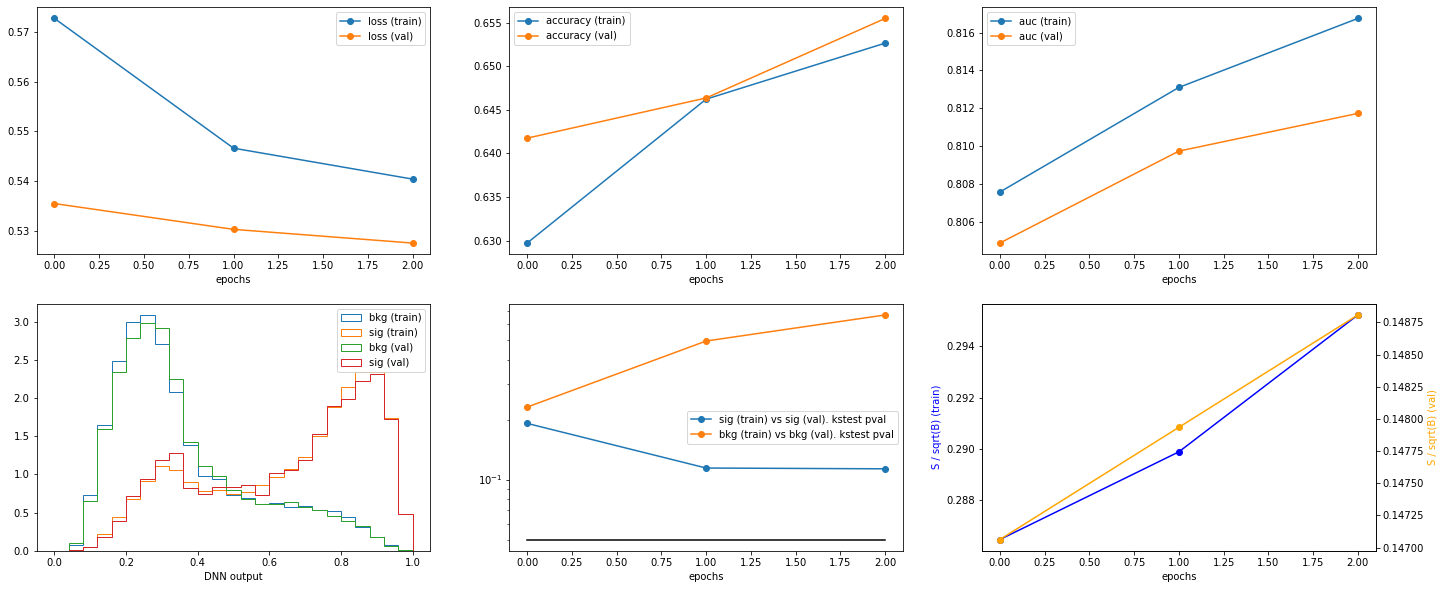

<Figure size 432x288 with 0 Axes>

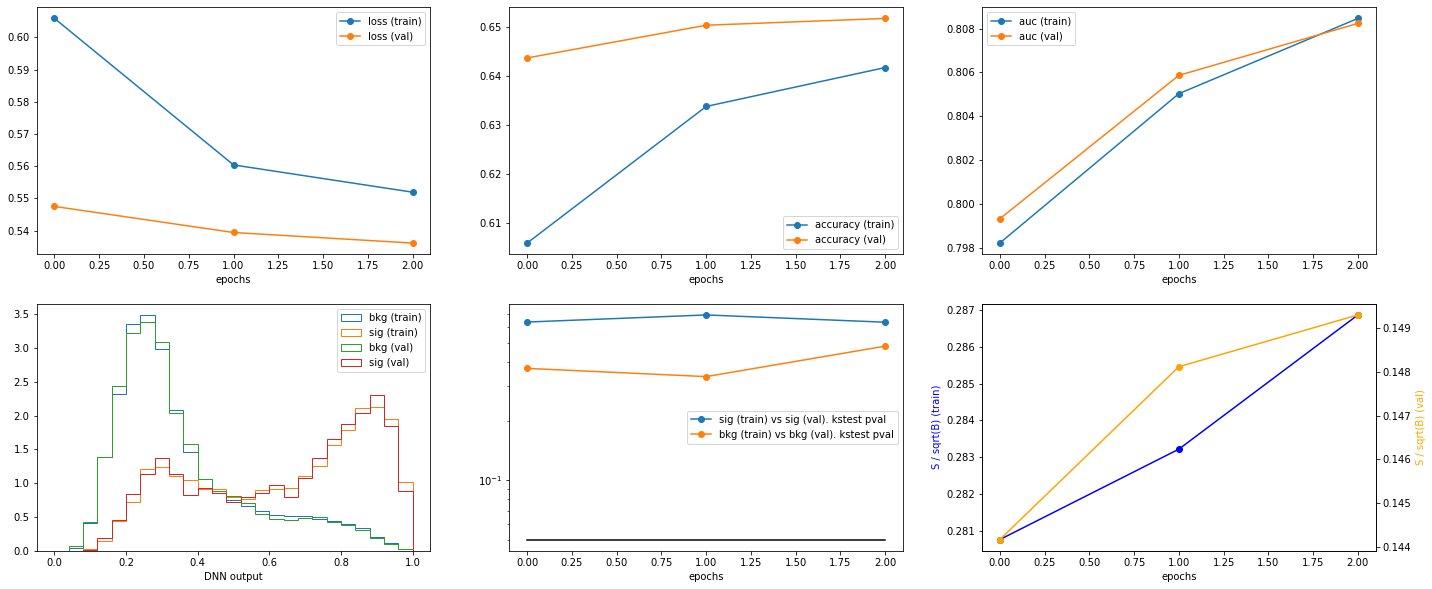

<Figure size 432x288 with 0 Axes>

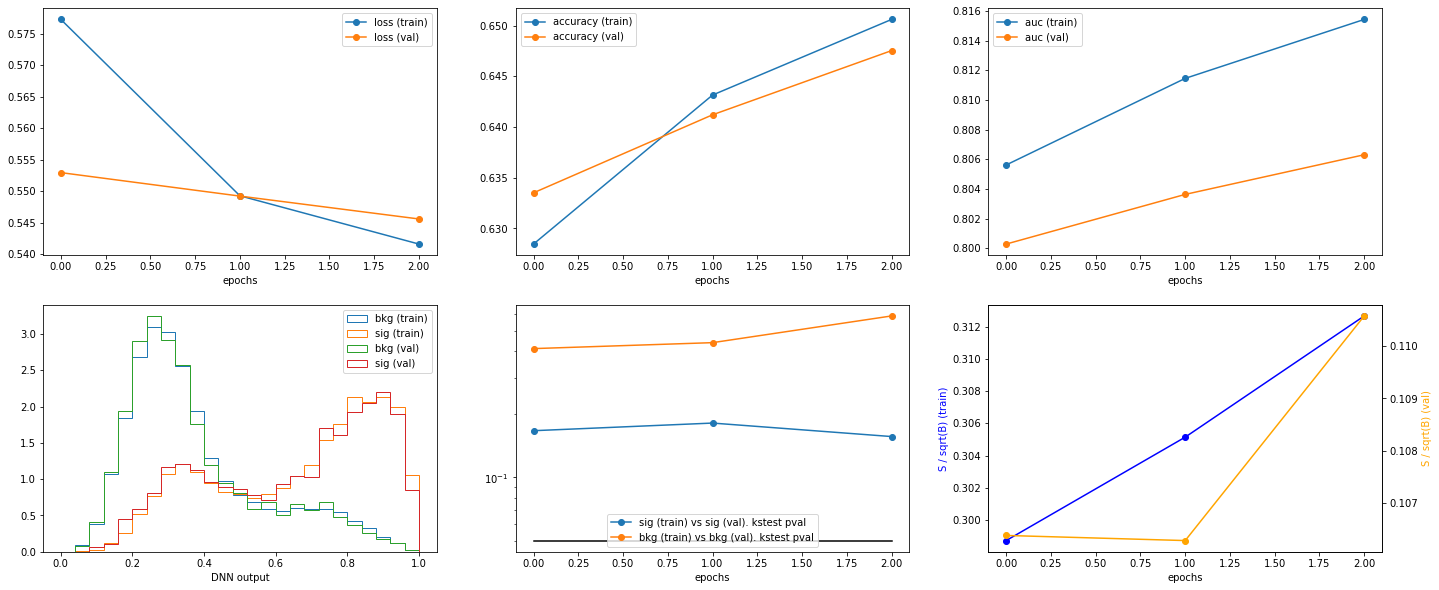

<Figure size 432x288 with 0 Axes>

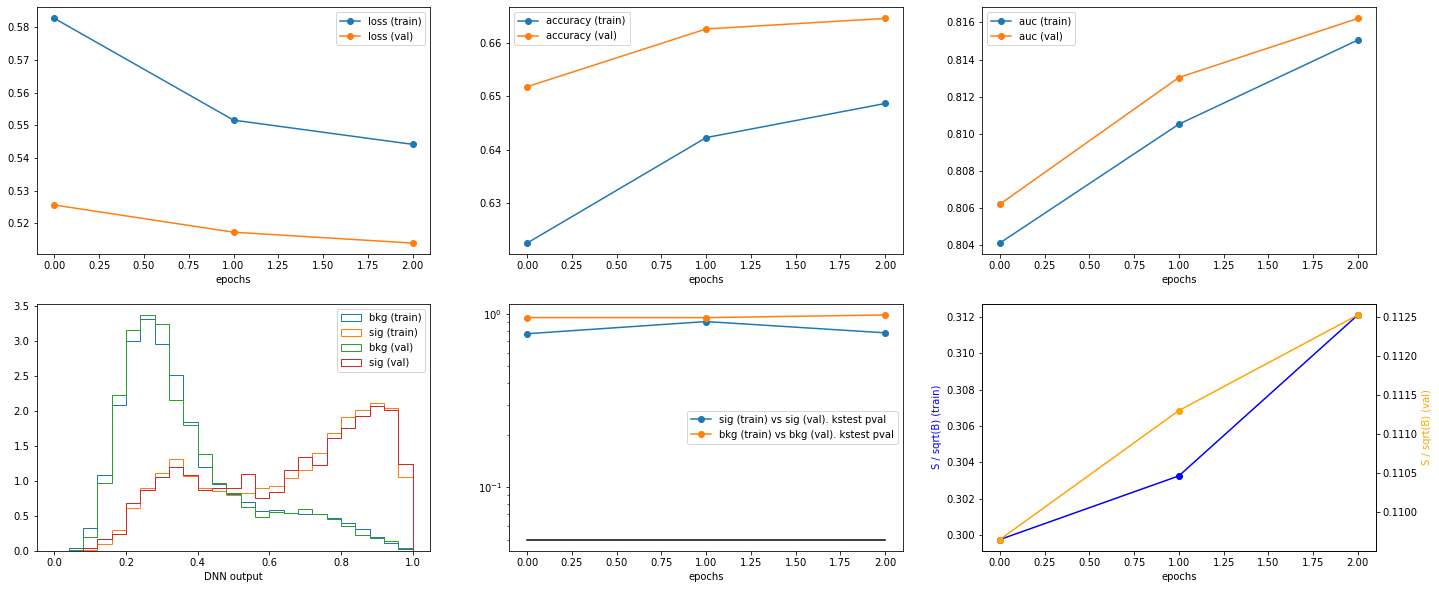

<Figure size 432x288 with 0 Axes>

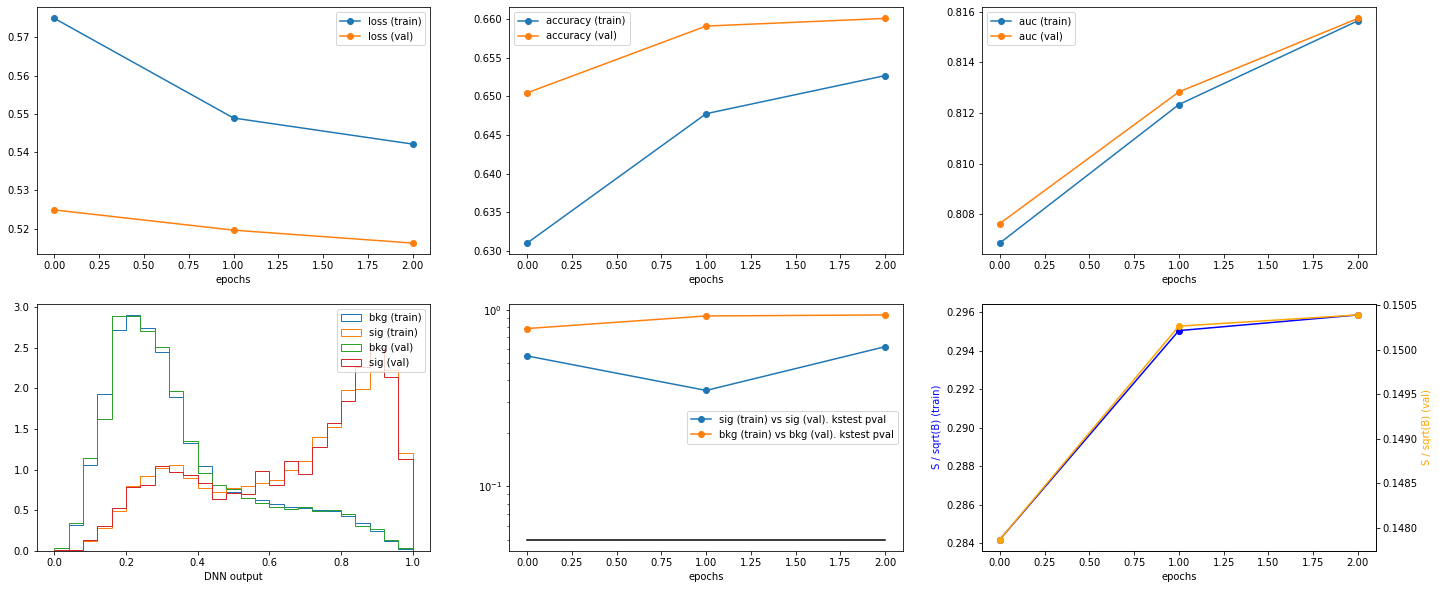

In [82]:
!time
opt_mnist = GPyOpt.methods.BayesianOptimization(f=f, domain=bounds)

user	0m0.56s
sys	0m0.63s


I0214 15:16:46.432395 140680182429504 gp.py:49] initializing Y
I0214 15:16:46.434334 140680182429504 gp.py:98] initializing inference method
I0214 15:16:46.435858 140680182429504 gp.py:107] adding kernel and likelihood as parameters
I0214 15:16:46.906027 140680182429504 model_opt.py:55] Loading data
I0214 15:16:46.907385 140680182429504 model_opt.py:60] 1581689806


[[  0.2 128. ]]


I0214 15:16:47.539399 140680182429504 model_opt.py:124] Creating model
I0214 15:16:48.147266 140680182429504 model_opt.py:187] Start Training
I0214 15:17:34.274529 140680182429504 model_opt.py:190] Saving training metadata


<Figure size 432x288 with 0 Axes>

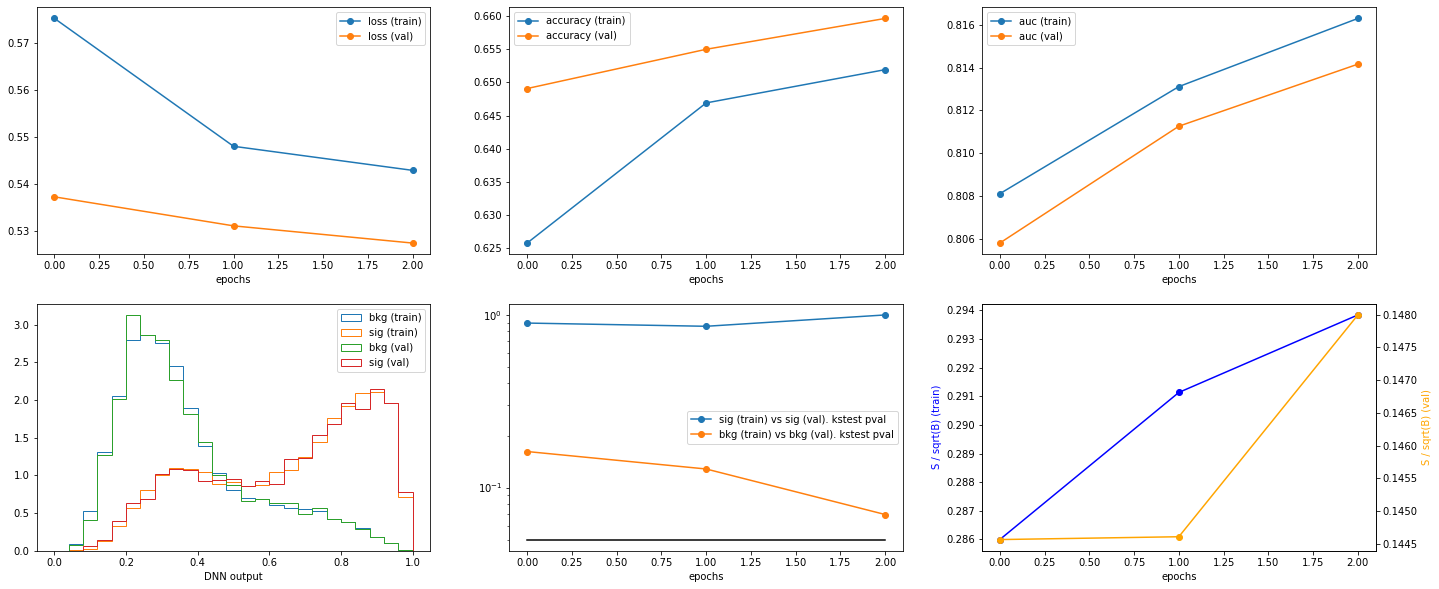

In [84]:
opt_mnist.run_optimization(max_iter=10)

In [87]:
print("""
Optimized Parameters:
\t{0}:\t{1}
\t{2}:\t{3}
""".format(
    bounds[0]["name"],opt_mnist.x_opt[0],
    bounds[1]["name"],opt_mnist.x_opt[1],
))
print("optimized loss: {0}".format(opt_mnist.fx_opt))


Optimized Parameters:
	test_ratio:	0.1
	batch_size:	256.0

optimized loss: 0.5144698499900197
